# 自適應增強決策樹分類(Adaptive Boosted Decision Tree Classifier)

##### 先引入我們需要的packages

In [1]:
import os 
import numpy as np
import random
import matplotlib.pyplot as plt
from random import choices

# Training Data

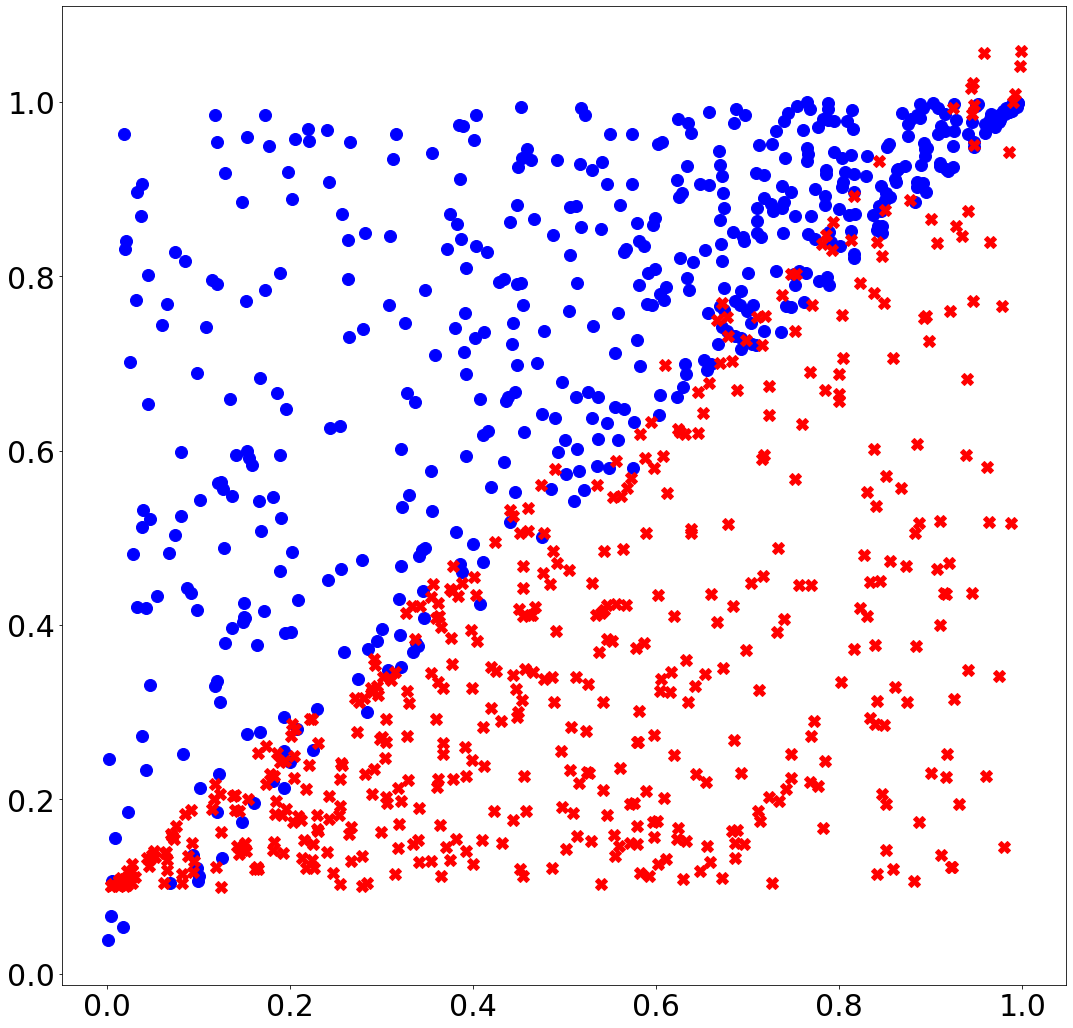

In [2]:
N=1000
x=np.zeros((N,2))
y=np.zeros(N)
for i in range(0,N): 
    f=-0.1
    if(i<N/2):
        y[i]=1
        x[i,0]=random.random()
        x[i,1]=random.uniform(x[i,0],1)
    else:
        y[i]=-1
        x[i,0]=random.random()
        x[i,1]=random.uniform(0,x[i,0])-f
plt.rcParams["figure.figsize"] = (18,18)
plt.plot(x[:500,0],x[:500,1],"bo",markersize=12)
plt.plot(x[500:,0],x[500:,1],"rX",markersize=12)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

# Testing Data

In [3]:
N_test=50
x_test=np.zeros((N_test,2))
y_test=np.zeros(N_test)
for i in range(0,N_test): 
    f=-0.1
    if(i<N_test/2):
        y_test[i]=1
        x_test[i,0]=random.random()
        x_test[i,1]=random.uniform(x_test[i,0],1)
    else:
        y_test[i]=-1
        x_test[i,0]=random.random()
        x_test[i,1]=random.uniform(0,x_test[i,0])-f

# Plot Decision Line

In [4]:
def plot_line(x_split,m,x_lim,color):
    """
    m:代表第m個feature
    x_split:分割線
    xlim:畫分割線的邊界
    xlim[0,0],xlim[0,1]-->分類區橫軸最小值和最大值
    xlim[1,0],xlim[1,1]-->分類區縱軸最小值和最大值
    ################################################
    Polygon為多邊型的意思，這裡我們用x_lim的四個極值座標來劃出分類區域
    """
    if(m==0):
        polygon = plt.Polygon([[x_split,x_lim[1,0]],[x_split,x_lim[1,1]],
                              [x_lim[0,0],x_lim[1,1]],[x_lim[0,0],x_lim[1,0]],
                              [x_split,x_lim[1,0]]],fc=color[0],alpha=1)
        ax.add_patch(polygon)
        polygon = plt.Polygon([[x_split,x_lim[1,0]],[x_split,x_lim[1,1]],
                              [x_lim[0,1],x_lim[1,1]],[x_lim[0,1],x_lim[1,0]],
                              [x_split,x_lim[1,0]]],fc=color[1],alpha=1)
        ax.add_patch(polygon)
    else:
        polygon = plt.Polygon([[x_lim[0,0],x_split],[x_lim[0,1],x_split],
                              [x_lim[0,1],x_lim[1,1]],[x_lim[0,0],x_lim[1,1]],
                               [x_lim[0,0],x_split]],fc=color[1],alpha=1)
        ax.add_patch(polygon)
        polygon = plt.Polygon([[x_lim[0,0],x_split],[x_lim[0,1],x_split],
                              [x_lim[0,1],x_lim[1,0]],[x_lim[0,0],x_lim[1,0]],
                               [x_lim[0,0],x_split]],fc=color[0],alpha=1)
        ax.add_patch(polygon)

# Compute Error

In [5]:
def Compute_Error(x,y,s_left,s_right,D):
    """
    s_left: 分到左邊的資料標號
    s_right: 分到右邊的資料編號
    D: 權重
    這裡的作用最主要為計算錯誤率
    計算方式可以比照文章公式
    """
    if(sum(y[s_left]==1)/len(s_left)>sum(y[s_right]==1)/len(s_right)):
        left_class,right_class=1,-1
    elif(sum(y[s_left]==1)/len(s_left)<sum(y[s_right]==1)/len(s_right)):
        left_class,right_class=-1,1
    else:
        if(sum(y[s_left]==-1)/len(s_left)>sum(y[s_right]==-1)/len(s_right)):
            left_class,right_class=-1,1
        else:
            left_class,right_class=-1,-1
    y_check=np.zeros(len(y))
    y_check[s_left],y_check[s_right]=left_class,right_class
    return sum(D*(y!=y_check))/sum(D)

# Decision Stump

In [6]:
def Decision_Stump(x,y,D):
    """
    impurity_x0: 用來放橫軸特徵的impurity候選值
    impurity_x1: 用來放縱軸特徵的impurity候選值
    x0_sort: 所有資料點橫軸座標排序
    x1_sort: 所有資料點縱軸座標排序
    x0_sort_index:所有資料點橫軸座標排序後所對應的index
    x1_sort_index:所有資料點縱軸座標排序後所對應的index
    """
    error_x0=np.zeros(len(y)-1)
    error_x1=np.zeros(len(y)-1)
    x0_sort=np.sort(x[:,0])
    x1_sort=np.sort(x[:,1])
    x0_sort_index=np.argsort(x[:,0])
    x1_sort_index=np.argsort(x[:,1])
    """
    這裡的演算法核心就是我們以排列好的橫軸和縱標
    從第一個資料開始分成兩半，然後並計算impurity值
    -->迴圈執行步驟
    1. 以橫軸的feature分成兩個subtree
    2. 計算對應的橫軸impirity值
    3. 以縱軸的feature分成兩個subtree
    4. 計算對應的縱軸impirity值
    """
    for i in range(1,len(y)):
        s_left,s_right=x0_sort_index[:i],x0_sort_index[i:]
        error_x0[i-1]=Compute_Error(x,y,s_left,s_right,D)
        s_left,s_right=x1_sort_index[:i],x1_sort_index[i:]
        error_x1[i-1]=Compute_Error(x,y,s_left,s_right,D)
    """
    比較橫軸和縱軸最小的impurity值，如果其中一個比較小就回傳切割線座標
    """
    if(min(error_x0)<min(error_x1)):
        x_split=(x0_sort[np.argmin(error_x0)]+x0_sort[np.argmin(error_x0)+1])/2
        return x_split,0,min(error_x0)
    else:
        x_split=(x1_sort[np.argmin(error_x1)]+x1_sort[np.argmin(error_x1)+1])/2
        return x_split,1,min(error_x1)

# Decision Tree Algorithms

In [7]:
def Decision_Tree(x,y,x_real,y_real,x_test,y_test,index,index_test,D,max_depth,x_lim,K,y_train,y_pred):
    """
    x: 輸入訓練資料(隨機取樣的數據)
    y: 輸出訓練資料(隨機取樣的數據)
    x_real: 輸入訓練資料(真實數據)
    y_real: 輸出訓練資料(真實數據)
    x_test: 輸入測試資料
    y_test: 輸出測試資料
    index: 當前輸入到決策樹演算法中的訓練資料編號
    index_test: 當前輸入到決策樹演算法中的測試資料編號
    D: 權重
    max_depth: 最大決策樹深度
    x_lim: 用來畫分割區域的座標
    K: 輸出資料的類別數目
    y_train: 於訓練集所預測的輸出值
    y_pred: 於測試集所預測的輸出值
    """
    """
    執行Decision Stump演算法算出最佳分割線
    得到第m特徵的分割線座標x_split後
    以x_split和m將訓練Decision Tree的訓練資料(隨機選取的)分成left和right兩部分
    """
    x_split,m,impurity=Decision_Stump(x,y,D)
    p=x[:,m]<x_split
    x_left,y_left=x[p],y[p]
    x_right,y_right=x[~p],y[~p]
    D_left,D_right=D[p],D[~p]
    """
    接著我們一樣以x_split和m，拆分我們的真實訓練資料和測試資料，所以這裡
    left_index和right_index分別代表在此Node的之下
    真實訓練資料分到左邊subtree的index和分到右邊subtree的index
    left_index_test和right_index_test分別代表在此Node的之下
    測試資料分到左邊subtree的index和分到右邊subtree的index
    """
    p_real=(x_real[:,m]<x_split).flatten()
    p_real_left=np.where(p_real)
    p_real_right=np.where(~p_real)
    left_index=np.intersect1d(p_real_left,index)
    right_index=np.intersect1d(p_real_right,index)
    p_test=(x_test[:,m]<x_split).flatten()
    p_test_left=np.where(p_test)
    p_test_right=np.where(~p_test)
    left_index_test=np.intersect1d(p_test_left,index_test)
    right_index_test=np.intersect1d(p_test_right,index_test)
    """
    而在這邊我們設定分類區域的背景顏色，然後劃出我們的分割區域
    畫完之後就重新更新我們左邊和右邊subtree的區域邊界x_lim_left和x_lim_right
    """
    if(sum(y_left==1)/len(y_left)>sum(y_right==1)/len(y_right)):
        color=["#7777FF","#FF7777"]
    elif(sum(y_left==1)/len(y_left)<sum(y_right==1)/len(y_right)):
        color=["#FF7777","#7777FF"]
    else:
        if(sum(y_left==-1)/len(y_left)>sum(y_right==-1)/len(y_right)):
            color=["#FF7777","#7777FF"]
        else:
            color=["#7777FF","#FF7777"]
    plot_line(x_split,m,x_lim,color)
    x_lim_left,x_lim_right=np.zeros((2,2)),np.zeros((2,2))
    if(m==0):
        x_lim_left[0,0],x_lim_left[0,1],x_lim_left[1,0],x_lim_left[1,1]=x_lim[0,0],x_split,x_lim[1,0],x_lim[1,1]
        x_lim_right[0,0],x_lim_right[0,1],x_lim_right[1,0],x_lim_right[1,1]=x_split,x_lim[0,1],x_lim[1,0],x_lim[1,1]
    else:
        x_lim_left[0,0],x_lim_left[0,1],x_lim_left[1,0],x_lim_left[1,1]=x_lim[0,0],x_lim[0,1],x_lim[1,0],x_split
        x_lim_right[0,0],x_lim_right[0,1],x_lim_right[1,0],x_lim_right[1,1]=x_lim[0,0],x_lim[0,1],x_split,x_lim[1,1]
    """
    更新完我們的區域邊界後，接下來就是檢查我們左邊和右邊的subtree
    他們是否已經分類完成，底下的類別全部相同。所以如果
    左邊的subtree分類完成check_left=True
    右邊的subtree分類完成check_right=True
    """
    check_left=True
    for i in range(0,len(y_left)):
        if(y_left[0]!=y_left[i]):
            check_left=False
            break
    check_right=True
    for i in range(0,len(y_right)):
        if(y_right[0]!=y_right[i]):
            check_right=False
            break
    """
    最後就是設定Decision Tree的停止條件
    1. impirity=0 / 2. 達到最大深度 / 3.左右兩邊subtree都完美分類好
    而這裡我們可以分成四個case
    (1) 達到Decision Tree停止條件
       --> 我們檢查左右兩邊Decision tree把他分成什麼類別後
           我們就將y_train和y_pred標註Decision Tree預測的類別，最後並回傳
    (2) 左邊的subtree分類完成，但是右邊的subtree還沒分好
       --> 我們檢查左邊的subtree的類別
           然後將左邊subtree的y_train和y_pred，標註Decision Tree所預測的類別
           接著將右邊subtree的資料帶入Decision Tree演算法繼續分類，最後並回傳
    (3) 右邊的subtree分類完成，但是左邊的subtree還沒分好
       --> 我們檢查右邊的subtree的類別
           然後將右邊subtree的y_train和y_pred，標註Decision Tree所預測的類別
           接著將左邊subtree的資料帶入Decision Tree演算法繼續分類，最後並回傳
    (4) 左右兩邊都沒有分好
       --> 將左邊和右邊的subtree都丟到Decision Tree演算法繼續分類，最後並回傳
    """
    if((impurity==0)or(max_depth==1)or((check_left)and(check_right))):
        if(sum(y_left==1)/len(y_left)>sum(y_right==1)/len(y_right)):
            label_left,label_right=1,-1
        elif(sum(y_left==1)/len(y_left)<sum(y_right==1)/len(y_right)):
            label_left,label_right=-1,1
        else:
            if(sum(y_left==-1)/len(y_left)>sum(y_right==-1)/len(y_right)):
                label_left,label_right=-1,1
            else:
                label_left,label_right=1,-1
        y_train[left_index],y_train[right_index]=label_left,label_right
        y_pred[left_index_test],y_pred[right_index_test]=label_left,label_right
        return y_train,y_pred
    elif(check_left):
        max_depth-=1
        y_train[left_index]=y_left[0]
        y_pred[left_index_test]=y_left[0]
        y_train,y_pred=Decision_Tree(x_right,y_right,x_real,y_real,x_test,y_test,
                                     right_index,right_index_test,D_right,max_depth,
                                     x_lim_right,K,y_train,y_pred)
        return y_train,y_pred
    elif(check_right):
        max_depth-=1
        y_train[right_index]=y_right[0]
        y_pred[right_index_test]=y_right[0]
        y_train,y_pred=Decision_Tree(x_left,y_left,x_real,y_real,x_test,y_test,
                                     left_index,left_index_test,D_left,max_depth,
                                     x_lim_left,K,y_train,y_pred)
        return y_train,y_pred
    else:
        max_depth-=1
        y_train,y_pred=Decision_Tree(x_left,y_left,x_real,y_real,x_test,y_test,
                                     left_index,left_index_test,D_left,max_depth,
                                     x_lim_left,K,y_train,y_pred)
        y_train,y_pred=Decision_Tree(x_right,y_right,x_real,y_real,x_test,y_test,
                                     right_index,right_index_test,D_right,max_depth,
                                     x_lim_right,K,y_train,y_pred)
        return y_train,y_pred

# Adaptive Boosted Decision Tree Classifier

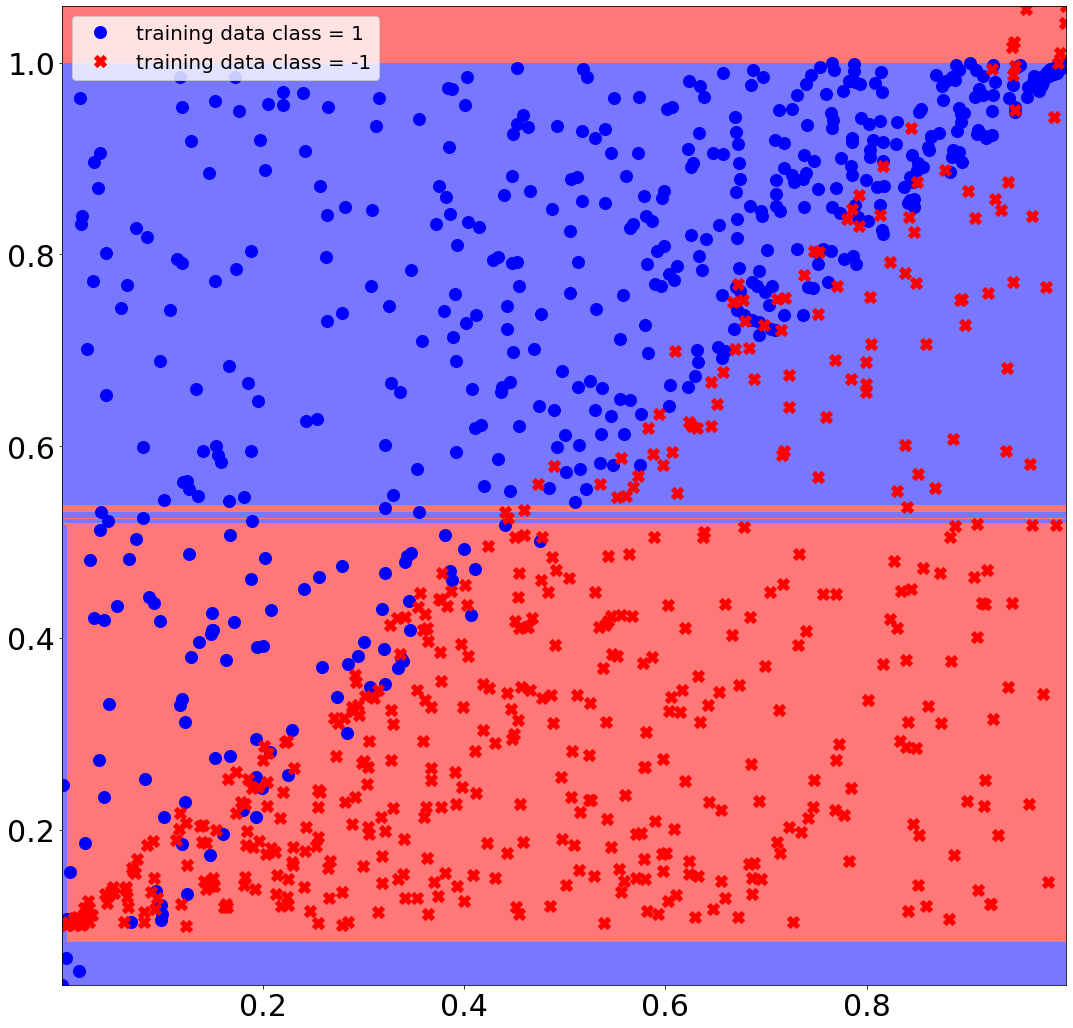

0.17900000000000002


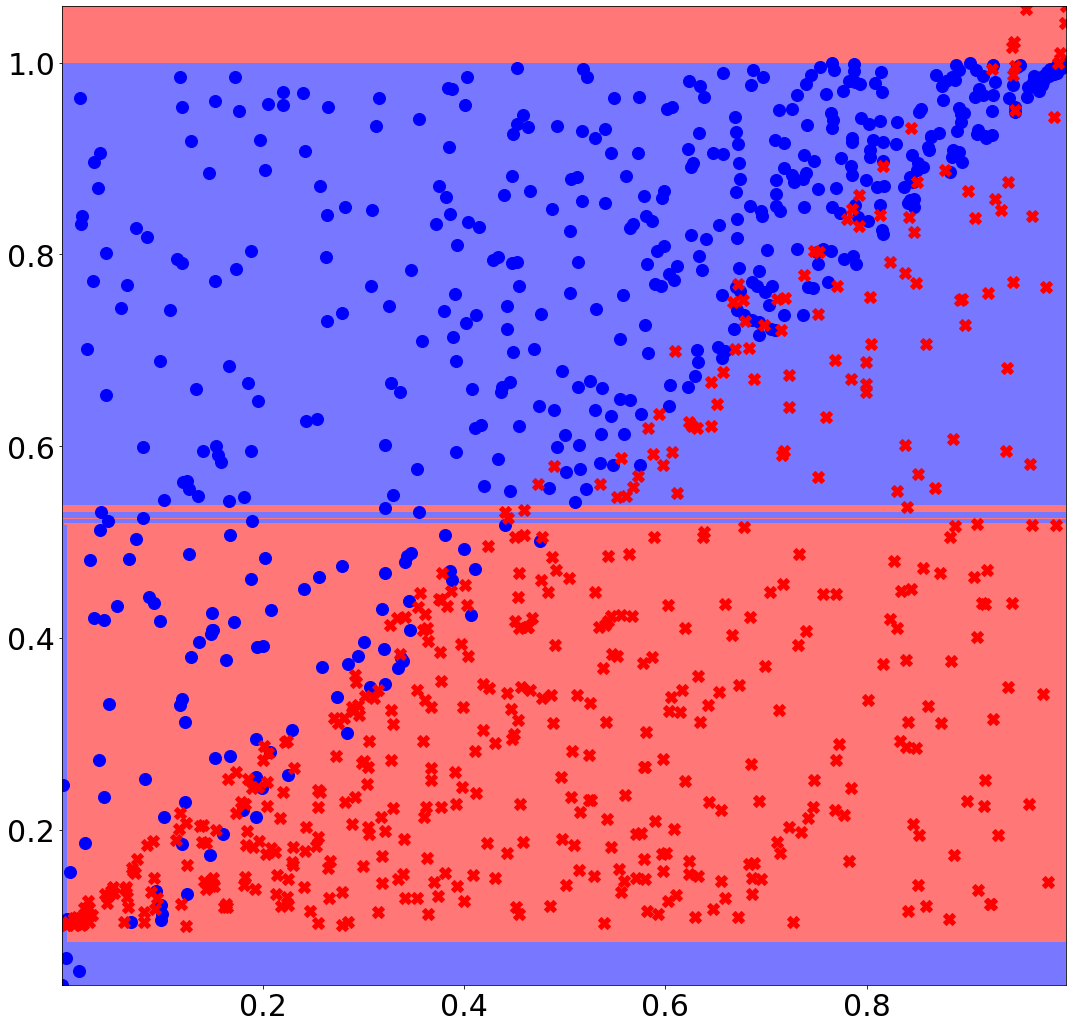

0.15893548540749722


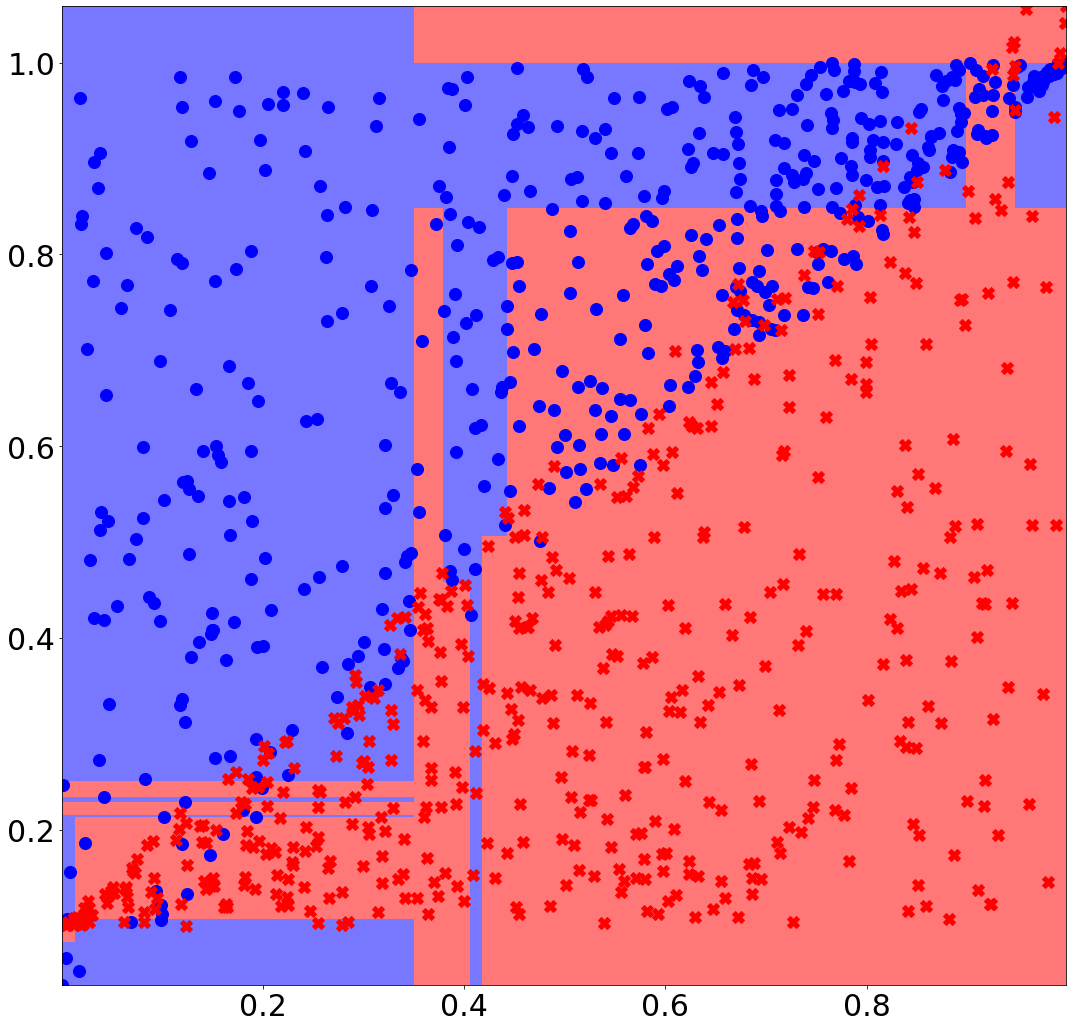

0.20940187019775525


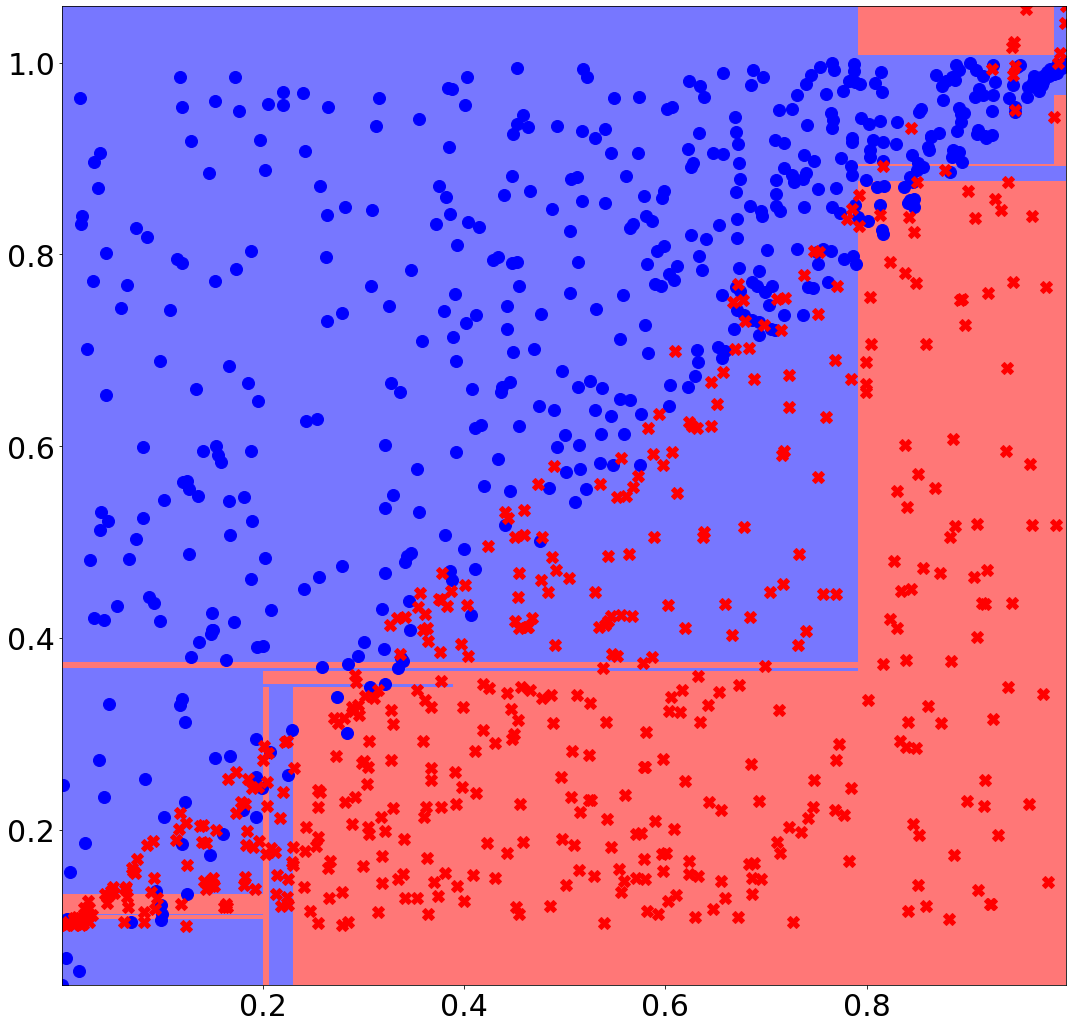

0.2939506034025045


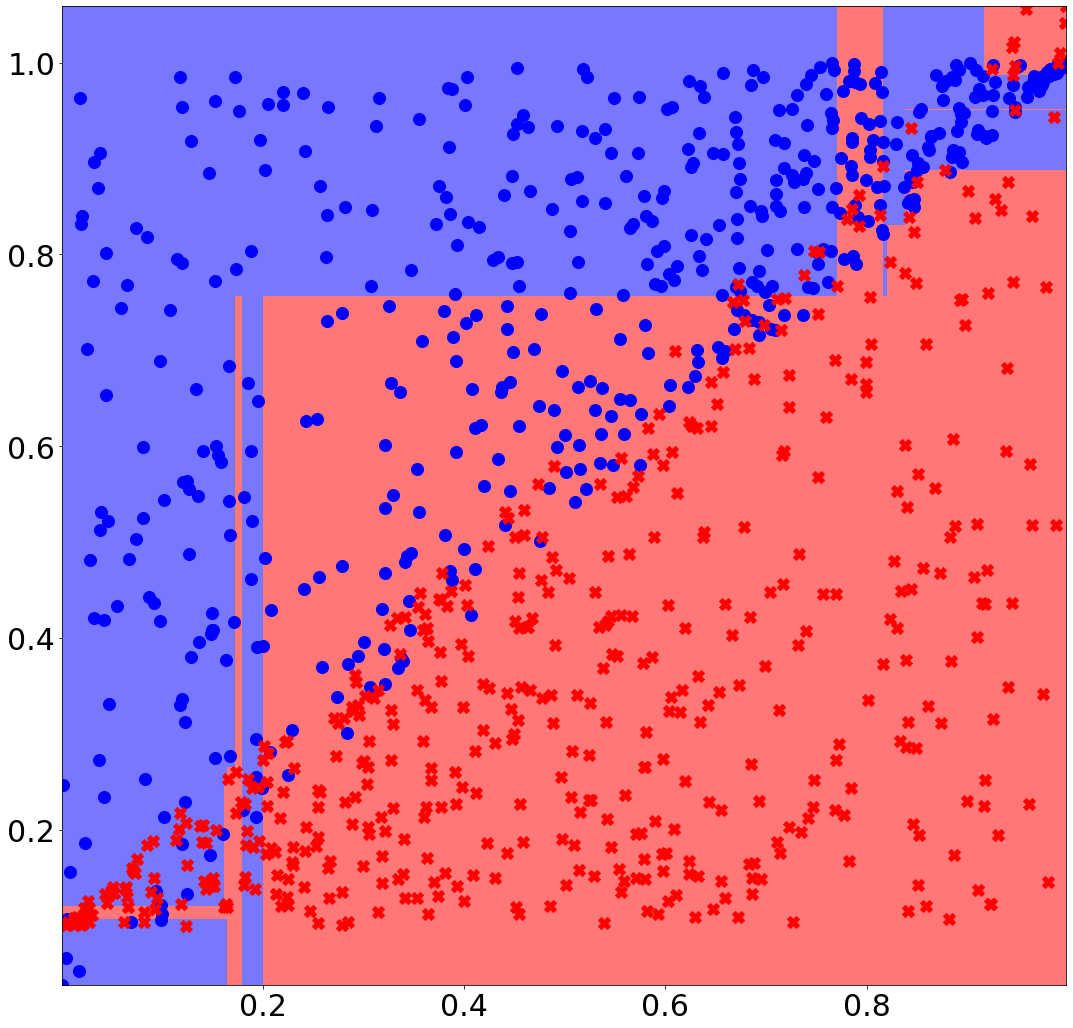

0.30651349779740916


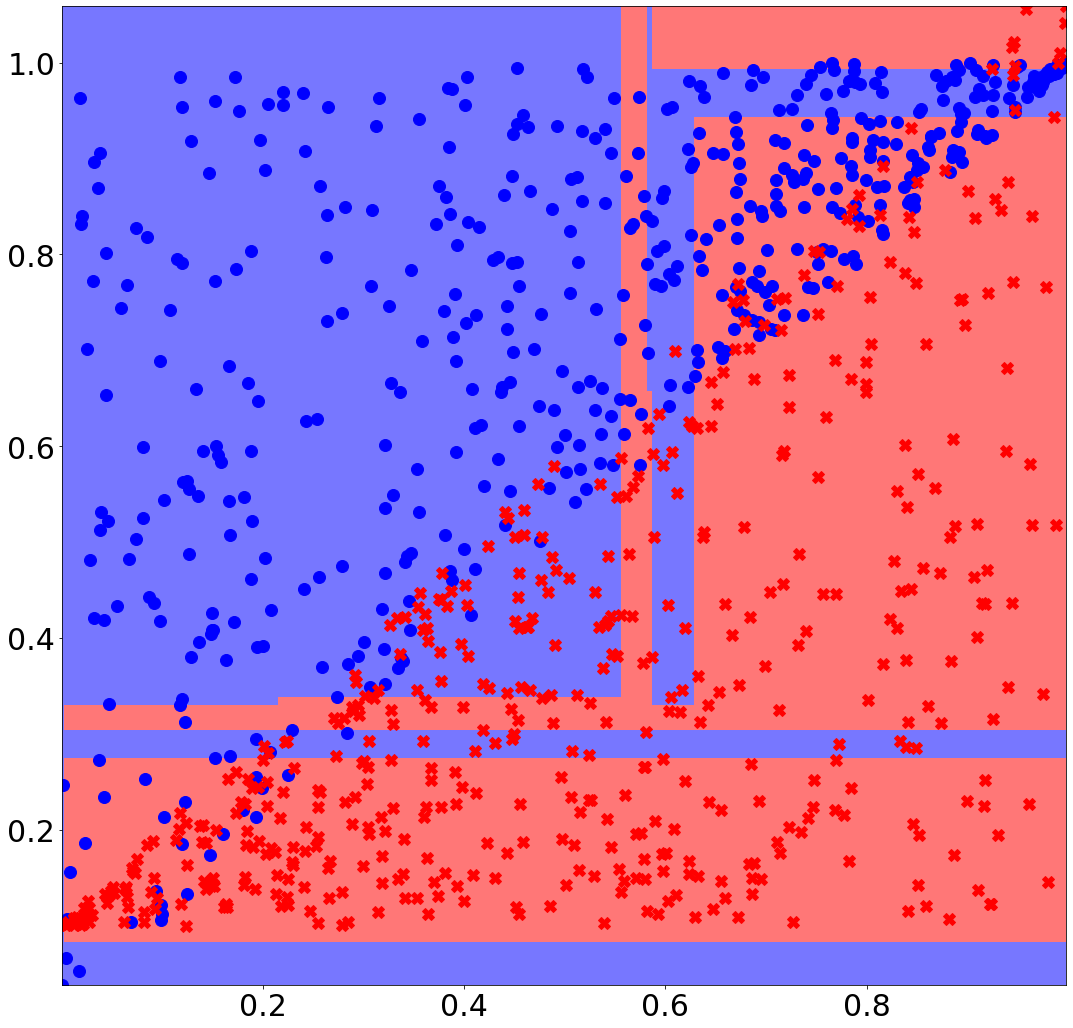

0.25013939487242276


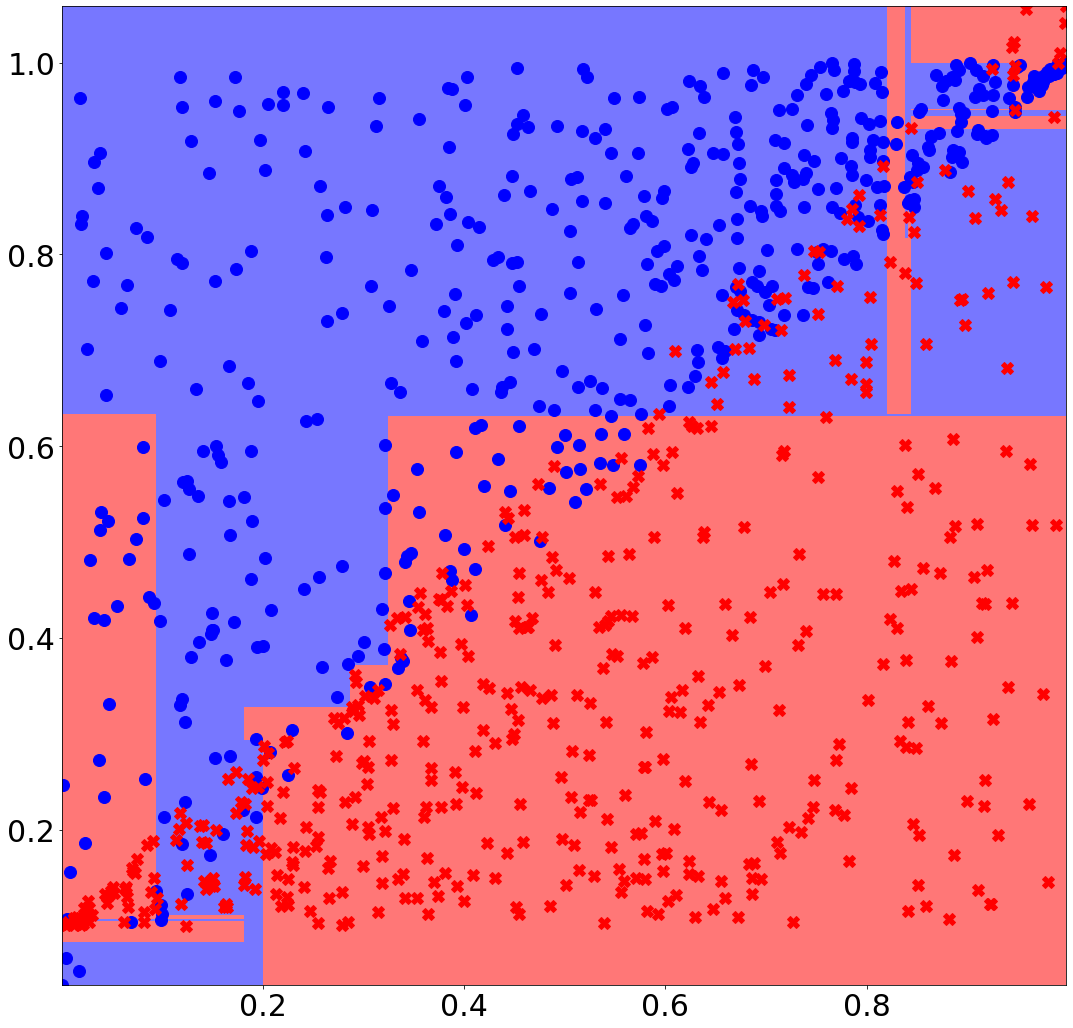

0.26519033500421596


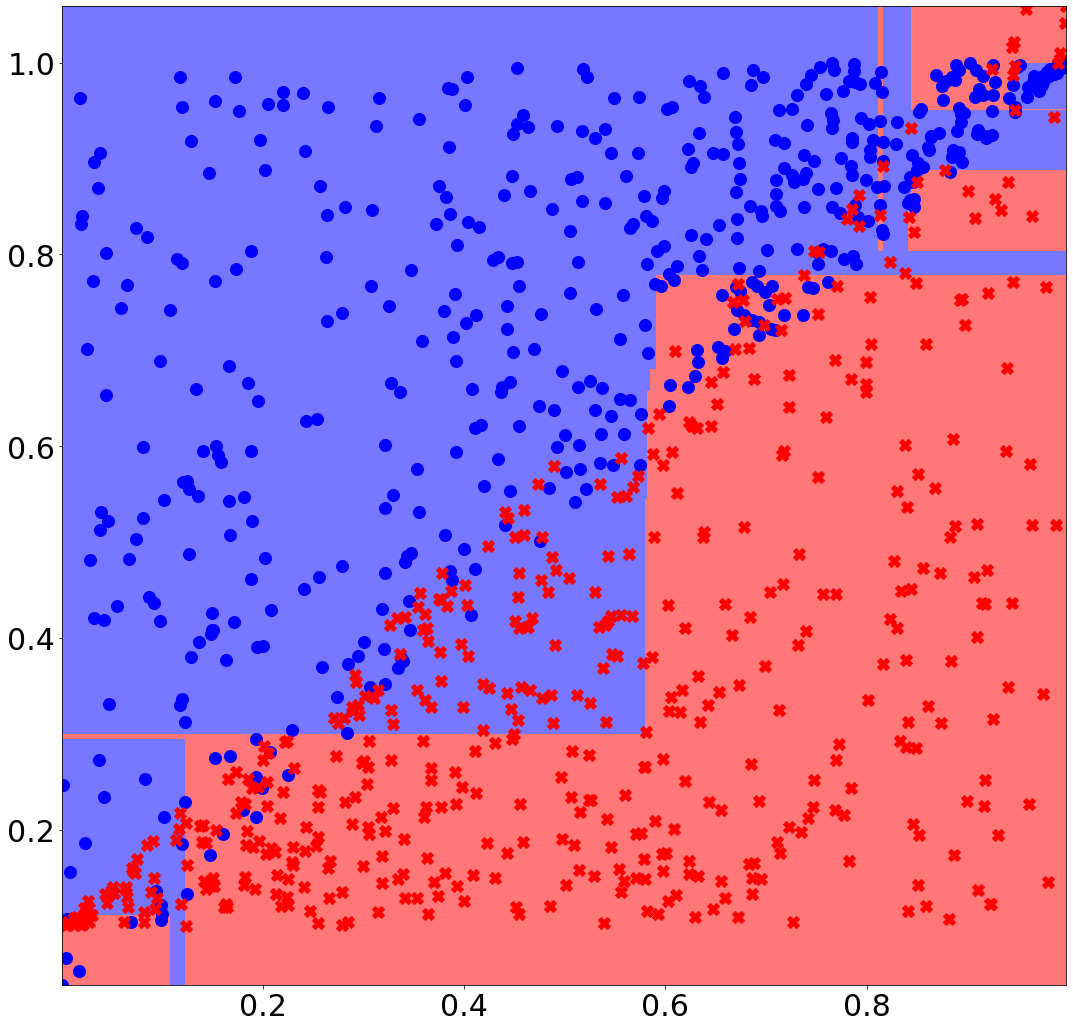

0.2837587824709117


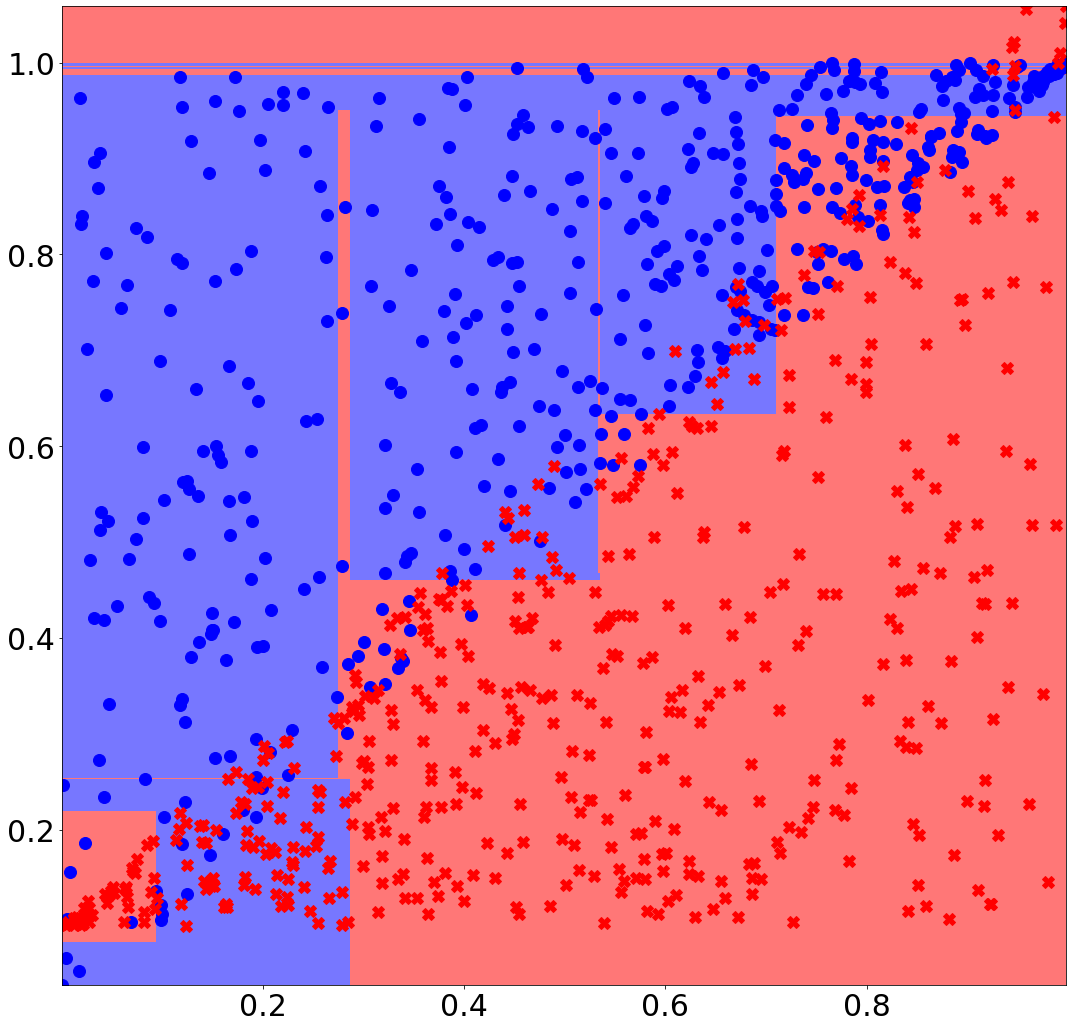

0.29365412946185543


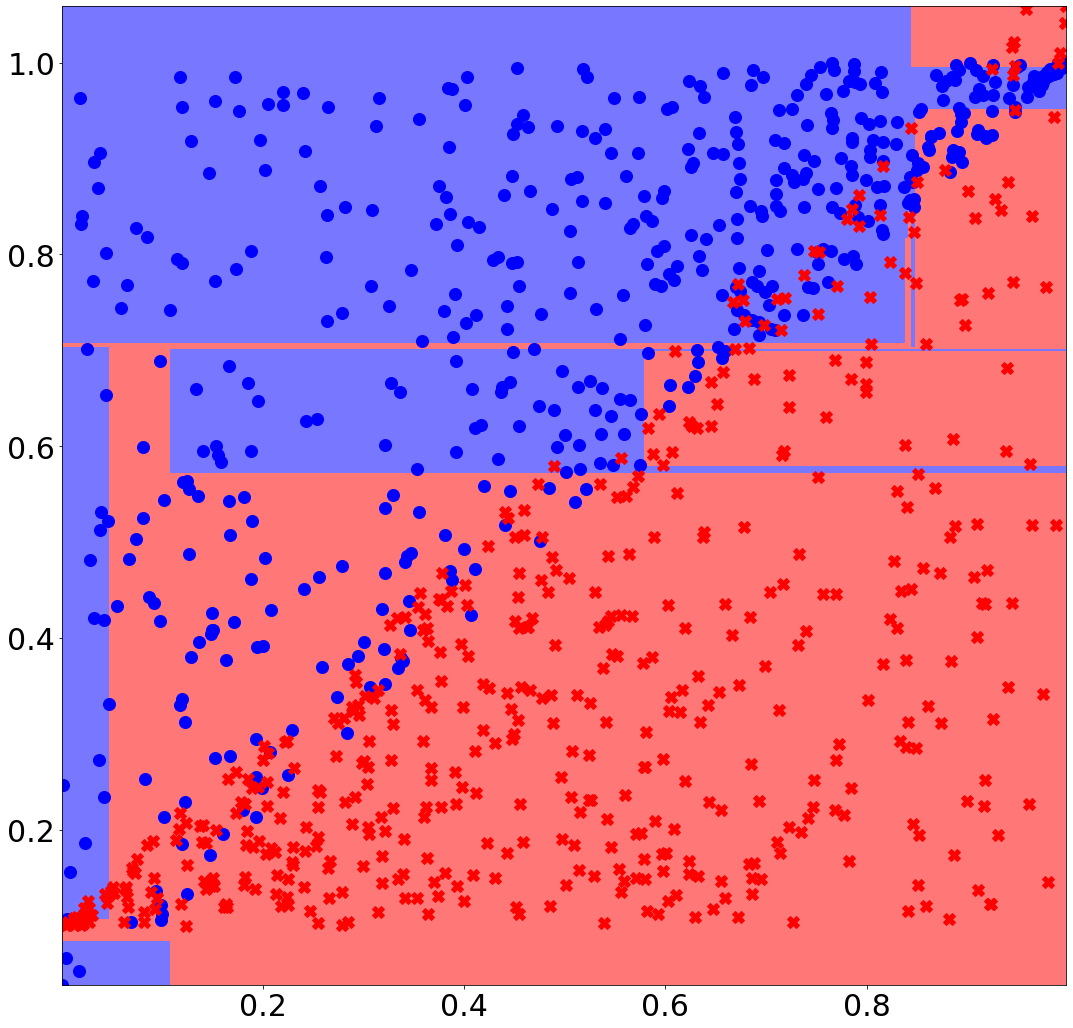

0.3508689427248354


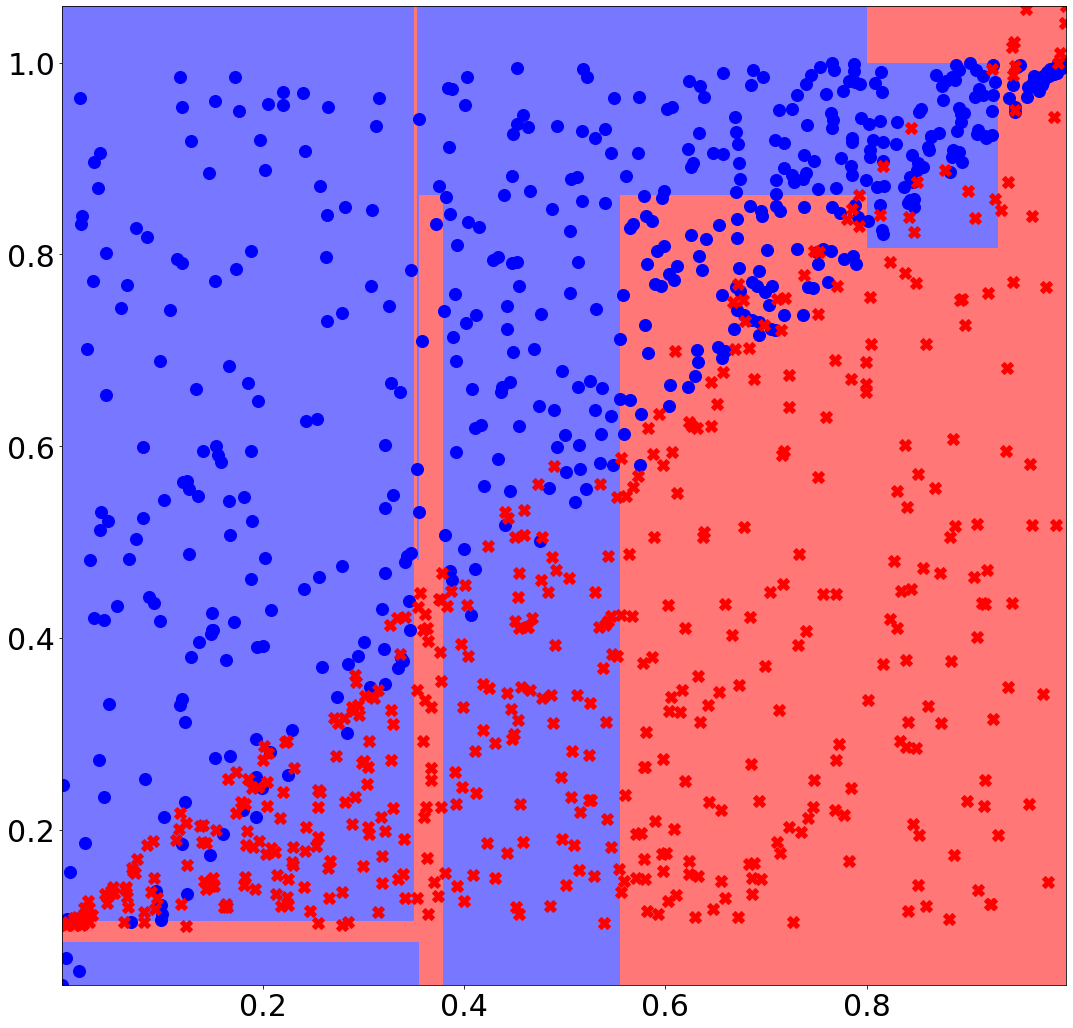

0.3436374070884731


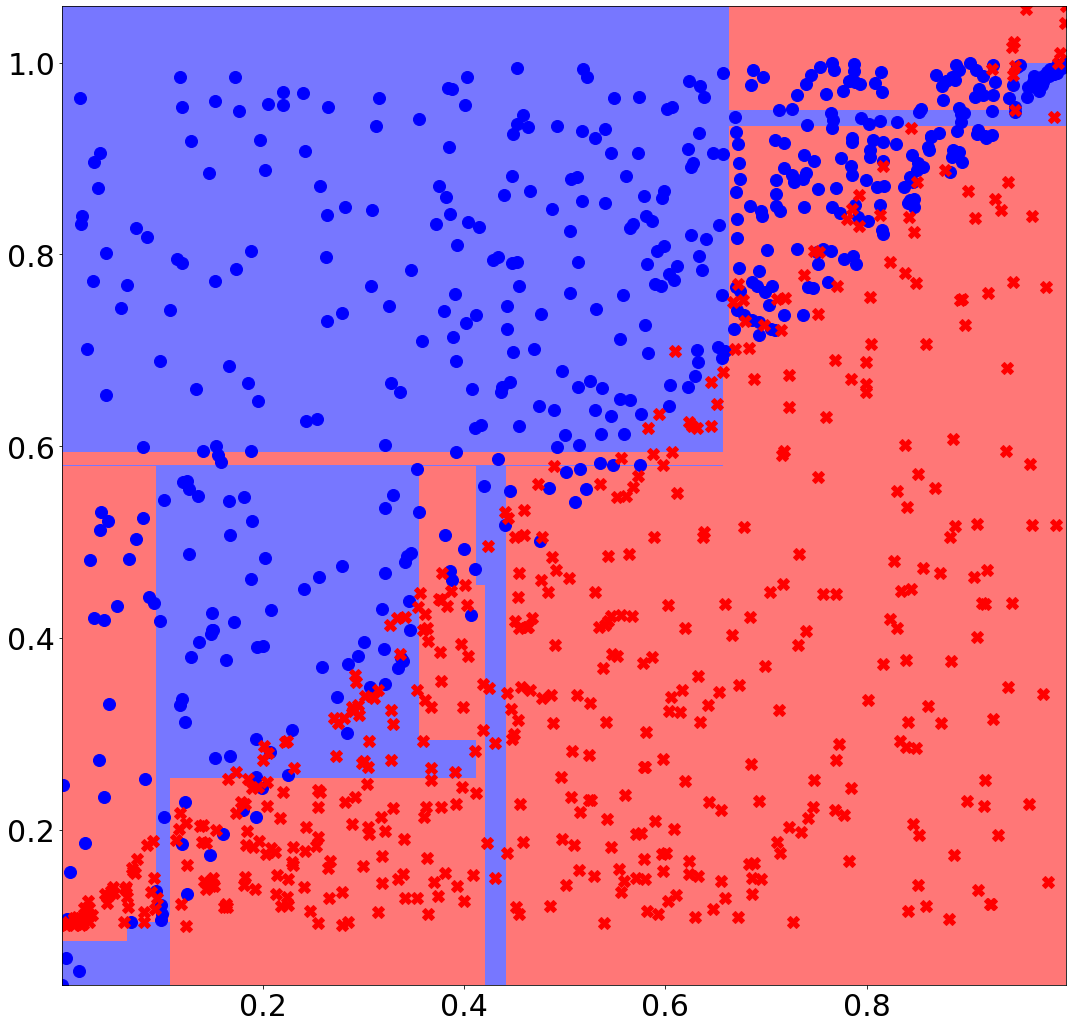

0.35064612330441536


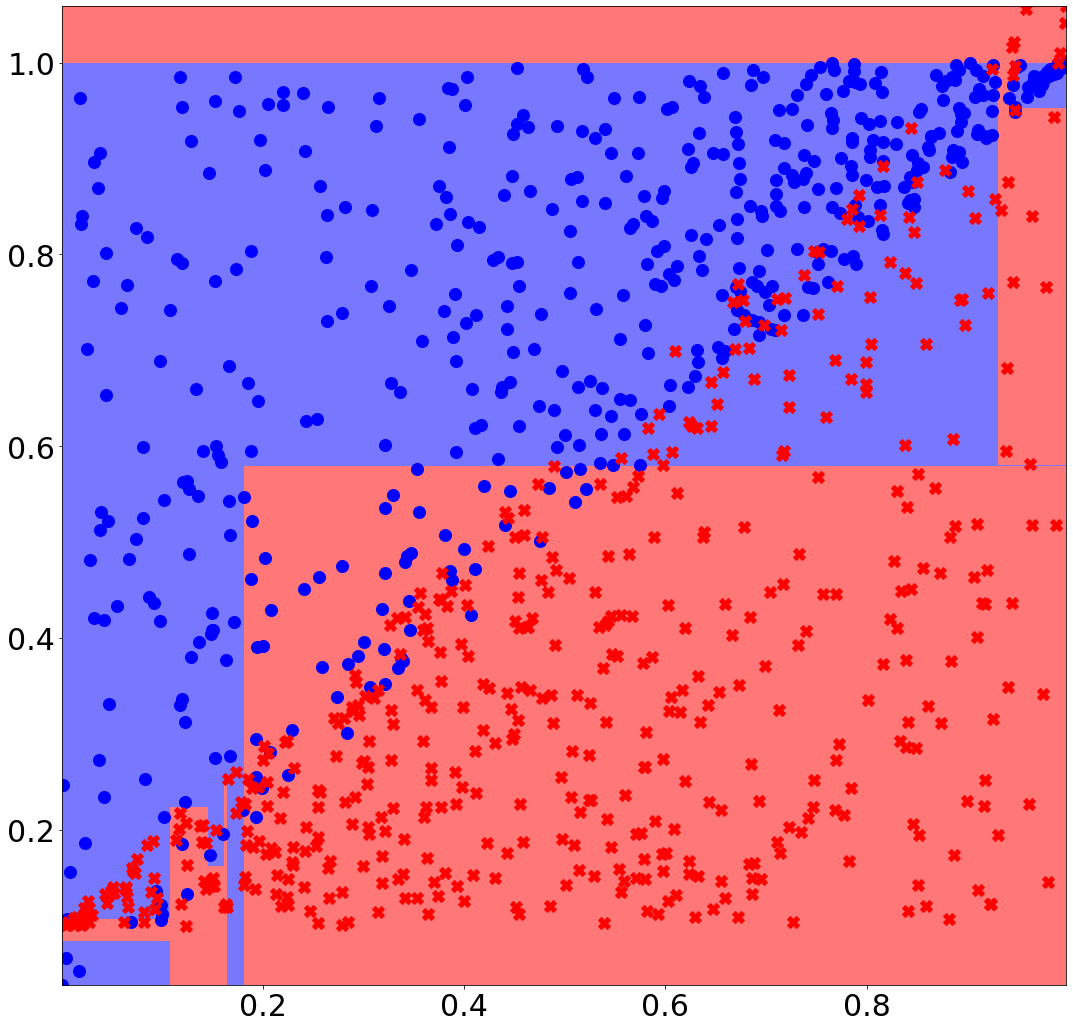

In [8]:
"""
Decision Tree
"""
x_lim=np.zeros((2,2))
x_lim[0,0],x_lim[0,1]=min(x[:,0]),max(x[:,0])
x_lim[1,0],x_lim[1,1]=min(x[:,1]),max(x[:,1])
y_train_DT=np.zeros(len(y))
y_pred_DT=np.zeros(len(y_test))
D=np.ones(N)/N
depth=5
fig = plt.figure()
ax = fig.add_subplot(111, xlim=(min(x[:,0]),max(x[:,0])), ylim=(min(x[:,1]),max(x[:,1])))
plt.rcParams["figure.figsize"] = (18,18)
y_train_DT,y_pred_DT=Decision_Tree(x,y,x,y,x_test,y_test,np.where(y),np.where(y_test),D,depth,
                                   x_lim,2,y_train_DT,y_pred_DT)
plt.plot(x[:500,0],x[:500,1],"bo",markersize=12,label="training data class = 1")
plt.plot(x[500:,0],x[500:,1],"rX",markersize=12,label="training data class = -1")
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)
plt.show()
"""
AdaBoost Decision Tree
"""
T=12
y_train=np.zeros((len(y),T))
y_pred=np.zeros((len(y_test),T))
D=np.ones(N)/N
new_D=np.ones(N)/N
a=np.zeros(T)
result=np.zeros(N)
result_test=np.zeros(N_test)
plt.rcParams["figure.figsize"] = (18,18)
y_train_ABDT=np.zeros(N)
y_pred_ABDT=np.zeros(N_test)
for i in range(0,T):
    fig = plt.figure()
    ax = fig.add_subplot(111, xlim=(min(x[:,0]),max(x[:,0])), ylim=(min(x[:,1]),max(x[:,1])))
    plt.rcParams["figure.figsize"] = (18,18)
    y_train[:,i],y_pred[:,i]=Decision_Tree(x,y,x,y,x_test,y_test,np.where(y),np.where(y_test),D,depth,
                                           x_lim,2,y_train[:,i],y_pred[:,i])
    error=sum(D*(y_train[:,i]!=y))/sum(D)
    print(error)
    if(error==0):
        T=i-1
        break
    a[i]=0.5*np.log((1-error)/error)
    y_train_ABDT+=a[i]*y_train[:,i]
    y_pred_ABDT+=a[i]*y_pred[:,i]
    D=D*np.exp(-a[i]*y*y_train[:,i])/sum(D)
    plt.plot(x[:500,0],x[:500,1],"bo",markersize=12)
    plt.plot(x[500:,0],x[500:,1],"rX",markersize=12)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.show()
y_train_ABDT=np.sign(y_train_ABDT)
y_pred_ABDT=np.sign(y_pred_ABDT)

In [9]:
print("------------------------------------Decision Tree------------------------------------")
print("The Decision Tree Training error rate:",sum(~(y_train_DT==y))/len(y),
      " / Testing error rate:",sum(~(y_pred_DT==y_test))/len(y_test))
print("------------------------------------AdaBoosted Decision Tree------------------------------------")
for i in range(0,T):
    print("The",i+1, "iteration individual tree alpha:",a[i],
          " / training error rate:",sum(~(y_train[:,i]==y))/len(y),
          " / Testing error rate:",sum(~(y_pred[:,i]==y_test))/len(y_test))
print("The AdaBoosted Decision Tree Training error rate:",sum(~(y_train_ABDT==y))/len(y),
      " / Testing error rate:",sum(~(y_pred_ABDT==y_test))/len(y_test))

------------------------------------Decision Tree------------------------------------
The Decision Tree Training error rate: 0.179  / Testing error rate: 0.2
------------------------------------AdaBoosted Decision Tree------------------------------------
The 1 iteration individual tree alpha: 0.7615686518058365  / training error rate: 0.179  / Testing error rate: 0.2
The 2 iteration individual tree alpha: 0.833085000533545  / training error rate: 0.2  / Testing error rate: 0.22
The 3 iteration individual tree alpha: 0.6642672778497729  / training error rate: 0.214  / Testing error rate: 0.24
The 4 iteration individual tree alpha: 0.43813673215645954  / training error rate: 0.241  / Testing error rate: 0.28
The 5 iteration individual tree alpha: 0.4082349916848937  / training error rate: 0.28  / Testing error rate: 0.26
The 6 iteration individual tree alpha: 0.548934493732064  / training error rate: 0.193  / Testing error rate: 0.26
The 7 iteration individual tree alpha: 0.5095818465086